In [1]:
%matplotlib inline
import sys

# Directories and paths
lib_path = '/gpfswork/rech/xdy/uze68md/GitHub/'
data_path = '/gpfswork/rech/xdy/uze68md/data/'
model_dir = '/gpfswork/rech/xdy/uze68md/trained_models/model_cfht/'

# Add library path to PYTHONPATH
path_alphatransform = lib_path+'alpha-transform'
path_score = lib_path+'score'
path_clean = '/gpfswork/rech/xdy/uze68md/GitHub/ShapeDeconv/data/T-RECS/clean/'
sys.path.insert(0, path_alphatransform)
sys.path.insert(0, path_score)
sys.path.insert(0, path_clean)

# Libraries
from CLEAN3 import doCLEAN,gauss2D
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import fft
import cadmos_lib as cl
import tensorflow as tf
import galsim
from galsim import Image
import galsim.hsm
import galflow as gf
from galaxy2galaxy import problems
import pickle
from cv2 import resize, INTER_AREA
from scipy.signal import convolve

# set random seed
tf.random.set_random_seed(2)

# Functions

def sigma_mad(signal):
    """This function returns the estimate of the standard deviation of White
    Additive Gaussian Noise using the Mean Absolute Deviation method (MAD).
    INPUT: signal, Numpy Array
    OUTPUT: sigma, scalar"""
    sigma = 1.4826*np.median(np.abs(signal-np.median(signal)))
    return sigma

def ir2tf_simplifie(imp_resp, shape):
    

    dim = 2
    # Zero padding and fill
    irpadded = np.zeros(shape)
    irpadded[tuple([slice(0, s) for s in imp_resp.shape])] = imp_resp
    # Roll for zero convention of the fft to avoid the phase
    # problem. Work with odd and even size.
    for axis, axis_size in enumerate(imp_resp.shape):

        irpadded = np.roll(irpadded,
                           shift=-int(np.floor(axis_size / 2)),
                           axis=axis)

    return fft.rfftn(irpadded, axes=range(-dim, 0))

def laplacian_simplifie(shape):
    
    impr = np.zeros([3,3])
    for dim in range(2):
        idx = tuple([slice(1, 2)] * dim +
                    [slice(None)] +
                    [slice(1, 2)] * (1 - dim))
        impr[idx] = np.array([-1.0,
                              0.0,
                              -1.0]).reshape([-1 if i == dim else 1
                                              for i in range(2)])
    impr[(slice(1, 2), ) * 2] = 4.0
    return ir2tf_simplifie(impr, shape), impr

def laplacian_tf(shape):
    return tf.convert_to_tensor(laplacian_simplifie(shape)[0])

def wiener_tf(image, psf, balance, laplacian=True):
    r"""Applies Wiener filter to image.

    This function takes an image in the direct space and its corresponding PSF in the
    Fourier space and performs a deconvolution using the Wiener Filter.

    Parameters
    ----------
    image   : 2D TensorFlow tensor
        Image in the direct space.
    psf     : 2D TensorFlow tensor
        PSF in the Fourier space (or K space).
    balance : scalar
        Weight applied to regularization.
    laplacian : boolean
        If true the Laplacian regularization is used else the identity regularization 
        is used.

    Returns
    -------
    tuple
        The first element is the filtered image in the Fourier space.
        The second element is the PSF in the Fourier space (also know as the Transfer
        Function).
    """
    trans_func = psf
    if laplacian:
        reg = laplacian_tf(image.shape)
        if psf.shape != reg.shape:
            trans_func = tf.signal.rfft2d(tf.signal.ifftshift(tf.cast(psf, 'float32')))
        else:
            trans_func = psf
    
    arg1 = tf.cast(tf.math.conj(trans_func), 'complex64')
    arg2 = tf.dtypes.cast(tf.math.abs(trans_func),'complex64') ** 2
    arg3 = balance
    if laplacian:
        arg3 *= tf.dtypes.cast(tf.math.abs(laplacian_tf(image.shape)), 'complex64')**2
    wiener_filter = arg1 / (arg2 + arg3)
    
    # Apply wiener in Foutier (or K) space
    wiener_applied = wiener_filter * tf.signal.rfft2d(tf.cast(image, 'float32'))
    
    return wiener_applied, trans_func

def pre_proc_unet(dico):
    r"""Preprocess the data and apply the Tikhonov filter on the input galaxy images.

    This function takes the dictionnary of galaxy images and PSF for the input and
    the target and returns a list containing 2 arrays: an array of galaxy images that
    are the output of the Tikhonov filter and an array of target galaxy images.

    Parameters
    ----------
    dico : dictionnary
        Array_like means all those objects -- lists, nested lists, etc. --
        that can be converted to an array.  We can also refer to
        variables like `var1`.

    Returns
    -------
    list
        list containing 2 arrays: an array of galaxy images that are the output of the
        Tikhonov filter and an array of target galaxy images.

    Example
    -------
    These are written in doctest format, and should illustrate how to
    use the function.

    >>> from galaxy2galaxy import problems # to list avaible problems run problems.available()
    >>> problem128 = problems.problem('attrs2img_cosmos_hst2euclide')
    >>> dset = problem128.dataset(Modes.TRAIN, data_dir='attrs2img_cosmos_hst2euclide')
    >>> dset = dset.map(pre_proc_unet)
    """
    # First, we interpolate the image on a finer grid
    x_interpolant=tf.image.ResizeMethod.BICUBIC
    interp_factor = 2
    Nx = 128
    Ny = 128
    
    dico['inputs'] = tf.image.resize(dico['targets'],
                                  [Nx*interp_factor, Ny*interp_factor],
                                  method=x_interpolant)
    
    # Second, we add noise
    sigma = 7e-4
    noise = tf.random_normal(shape=tf.shape(dico['inputs']), mean=0.0, stddev=sigma, dtype=tf.float32)
    dico['inputs'] = dico['inputs'] + noise
    dico['psf'] = tf.cast(dico['psf'][...,0]/tf.math.reduce_max(dico['psf'][...,0]), dtype=tf.complex64)
    dico['mask'] = tf.identity(dico['psf'])
    dico['inputs'] = tf.signal.rfft2d(dico['inputs'][...,0])
    dico['inputs'] = tf.expand_dims(dico['inputs'], axis=0)
    dico['psf'] = tf.expand_dims(dico['psf'], axis=0)
    dico['inputs'] = gf.kconvolve(dico['inputs'], dico['psf'],
                   interp_factor=interp_factor)[0]
    dico['psf'] = tf.signal.ifftshift(tf.signal.irfft2d(dico['psf'], fft_length=[2*Nx,2*Ny]))
    dico['psf'] = tf.expand_dims(dico['psf'][0], axis=-1)
    
    # Third, we normalize the Unet inputs to improve the training
    norm_factor = 5e2
    dico['inputs'] = dico['inputs']*norm_factor
    dico['targets'] = dico['targets']*norm_factor

    # Fourth, we compute the Tikhonet solution for the input
    # Since we lower the resolution of the image, we also scale the flux
    # accordingly
    dico['inputs'] = tf.image.resize(dico['inputs'],
                                  [Nx*interp_factor, Ny*interp_factor],
                                  method=x_interpolant)
    dico['inputs'] = dico['inputs'] / interp_factor**2
    
    # Fifth, we scale the tikhonet solutions back to the initial size
    balance = 1e-2
    dico['inputs_tikho'], _ = wiener_tf(dico['inputs'][...,0], dico['mask'], balance)
    dico['inputs_tikho'] = tf.expand_dims(tf.signal.irfft2d(dico['inputs_tikho']), axis=-1)
    dico['inputs_tikho'] = tf.image.resize(dico['inputs_tikho'],
                                  [Nx, Ny],
                                  method=x_interpolant)
#     dico['inputs'] = tf.image.resize(dico['inputs'],
#                                   [Nx, Ny],
#                                   method=x_interpolant)
#     dico['psf'] = tf.image.resize(dico['psf'],
#                                   [Nx, Ny],
#                                   method=x_interpolant)
#     dico['psf'] = dico['psf']/tf.math.reduce_max(dico['psf'])
    dico['inputs_tikho'] = tf.image.central_crop(dico['inputs_tikho'], 0.5)
    dico['targets'] = tf.image.central_crop(dico['targets'], 0.5)
    
    return dico

In [2]:
# Let's create an instance of the hsc_problem
Modes = tf.estimator.ModeKeys
problem128 = problems.problem('meerkat_3600')
dset = problem128.dataset(Modes.EVAL, data_dir=data_path+'meerkat_3600')
dset = dset.repeat()
dset = dset.map(pre_proc_unet)

n_batch = 32

dset = dset.batch(n_batch)


INFO:tensorflow:Reading data files from /gpfswork/rech/xdy/uze68md/data/meerkat_3600/meerkat_3600-dev*
INFO:tensorflow:partition: 0 num_data_files: 2

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.




/gpfslocalsup/pub/anaconda-py3/2019.10/envs/tensorflow-gpu-1.15.2/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Seed 2 from outer graph might be getting used by function Dataset_map_pre_proc_unet, if the random op has not been provided any seed. Explicitly set the seed in the function if this is not the intended behavior.
  


In [3]:
# Build an iterator over the dataset
iterator = dset.make_one_shot_iterator().get_next()
sess = tf.Session()

# Initialize batch
batch = sess.run(iterator)
sess.close()

Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.


In [4]:
sigma = 7e-4
i=0
dirty = batch['inputs'][i,...,0]
PSF = batch['psf'][i,...,0]
batch['psf'][i,...,0].shape

(256, 256)

In [5]:
np.max(batch['inputs'][1])>2*sigma

True

In [6]:
batch['targets'].mean()

0.011515472

In [7]:
batch['inputs_tikho'].mean()

0.011266206

In [8]:
batch['inputs'][i,...,0].shape

(256, 256)

In [9]:
print(i)

0


In [10]:
restored,restorednores,residual,skymodelimg = np.zeros((4,n_batch,256,256))
skymodellist = []
i3 = [3]
for i in range(n_batch):#[i3]
    # running CLEAN
    print(i)
    sigma_im = sigma_mad(batch['inputs'][i,...,0])
    n=3
    while np.max(batch['inputs'][i])<n*sigma_im:
        n = n-1
    print('n :',n)
    restored[i],restorednores[i],residual[i],skymodellist_temp,skymodelimg[i]=doCLEAN(batch['inputs'][i,...,0],batch['psf'][i,...,0],gain=0.1,niter=5000,fthresh=n*sigma_im)
    skymodellist += [skymodellist_temp]

0
n : 3
1
n : 3
2
n : 3
3
n : 3
4
n : 3
5
n : 3
6
n : 3
7
n : 3
8
n : 3
9
n : 3
10
n : 3
11
n : 3
12
n : 3
13
n : 3
14
n : 3
15
n : 3
16
n : 3
17
n : 3
18
n : 3
19
n : 3
20
n : 3
21
n : 3
22
n : 2
23
n : 3
24
n : 3
25
n : 3
26
n : 3
27
n : 3
28
n : 3
29
n : 3
30
n : 3
31
n : 3


3


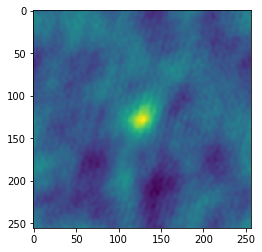

In [11]:
i=6
plt.imshow(batch['inputs'][i,...,0]);print(n)

Text(0, 0.5, 'y')

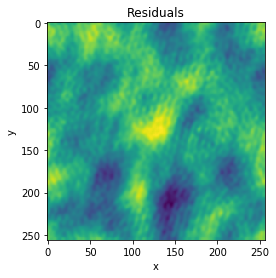

In [12]:
plt.imshow(residual[i], interpolation='none')
plt.title('Residuals')
plt.xlabel('x')
plt.ylabel('y')

/gpfslocalsup/pub/anaconda-py3/2019.10/envs/tensorflow-gpu-1.15.2/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log10
  """Entry point for launching an IPython kernel.
/gpfslocalsup/pub/anaconda-py3/2019.10/envs/tensorflow-gpu-1.15.2/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/gpfslocalsup/pub/anaconda-py3/2019.10/envs/tensorflow-gpu-1.15.2/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([1.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        1.000e+00, 2.000e+00, 2.000e+00, 0.000e+00, 5.000e+00, 7.000e+00,
        7.000e+00, 2.100e+01, 2.000e+01, 4.100e+01, 7.200e+01, 8.600e+01,
        1.400e+02, 2.550e+02, 3.340e+02, 5.430e+02, 8.370e+02, 1.414e+03,
        2.107e+03, 2.913e+03, 4.468e+03, 6.888e+03, 9.430e+03, 6.630e+03,
        1.824e+03]),
 array([-7.47012602, -7.27898053, -7.08783504, -6.89668955, -6.70554407,
        -6.51439858, -6.32325309, -6.1321076 , -5.94096212, -5.74981663,
        -5.55867114, -5.36752565, -5.17638017, -4.98523468, -4.79408919,
        -4.6029437 , -4.41179821, -4.22065273, -4.02950724, -3.83836175,
        -3.64721626, -3.45607078, -3.26492529, -3.0737798 , -2.88263431,
        -2.69148883, -2.50034334, -2.30919785, -2.11805236, -1.92690688,
        -1.73576139, -1.5446159 ]),
 <a list of 31 Patch objects>)

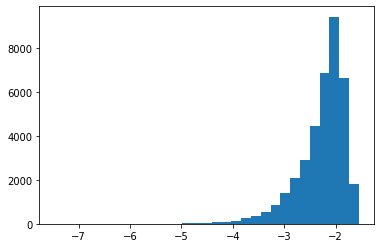

In [13]:
plt.hist(np.log10(residual[i].flatten()),bins=31)

(array([ 109.,  221.,  469.,  873., 1213., 1513., 2099., 2787., 3642.,
        4084., 4493., 4430., 4584., 4594., 4815., 4684., 3974., 3417.,
        2781., 2151., 2103., 1497.,  980.,  867.,  798.,  616.,  435.,
         314.,  297.,  338.,  358.]),
 array([-1.78728551e-02, -1.65910086e-02, -1.53091621e-02, -1.40273156e-02,
        -1.27454691e-02, -1.14636226e-02, -1.01817761e-02, -8.89992960e-03,
        -7.61808311e-03, -6.33623661e-03, -5.05439012e-03, -3.77254362e-03,
        -2.49069713e-03, -1.20885063e-03,  7.29958617e-05,  1.35484236e-03,
         2.63668885e-03,  3.91853535e-03,  5.20038184e-03,  6.48222834e-03,
         7.76407483e-03,  9.04592133e-03,  1.03277678e-02,  1.16096143e-02,
         1.28914608e-02,  1.41733073e-02,  1.54551538e-02,  1.67370003e-02,
         1.80188468e-02,  1.93006933e-02,  2.05825398e-02,  2.18643863e-02]),
 <a list of 31 Patch objects>)

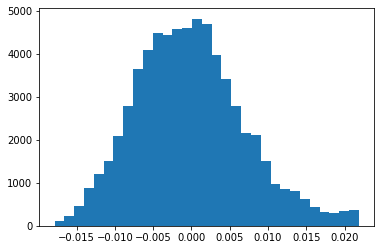

In [14]:
plt.hist(residual[3].flatten(),bins=31)

Text(0, 0.5, 'y')

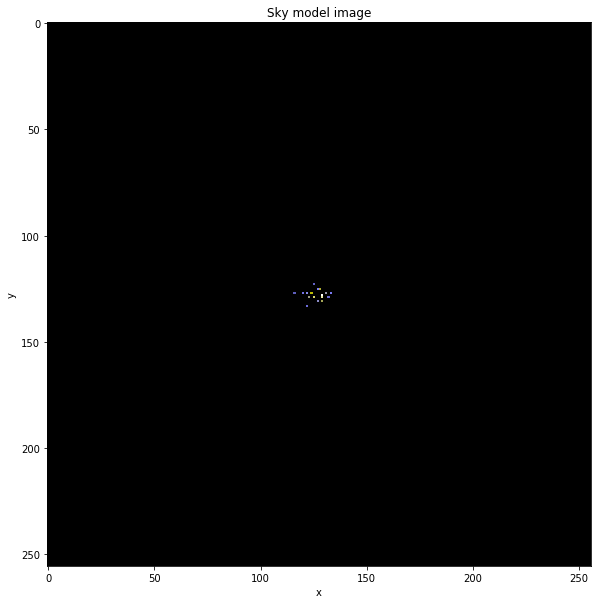

In [15]:
f=plt.figure(figsize=(10,10))
plt.imshow(np.log10(np.abs(skymodelimg[i])+1), cmap='gist_stern',interpolation='none')
plt.title('Sky model image')
plt.xlabel('x')
plt.ylabel('y')

Text(0, 0.5, 'y')

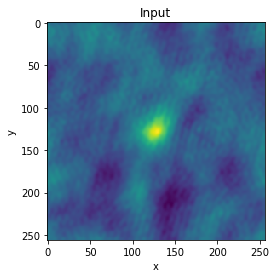

In [16]:
plt.imshow(batch['inputs'][i,...,0], interpolation='none')
plt.title('Input')
plt.xlabel('x')
plt.ylabel('y')

Text(0, 0.5, 'y')

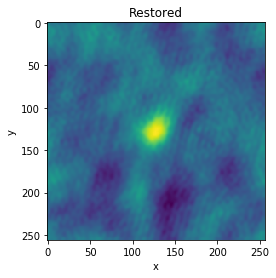

In [17]:
plt.imshow(restored[i], interpolation='none')
plt.title('Restored')
plt.xlabel('x')
plt.ylabel('y')

Text(0, 0.5, 'y')

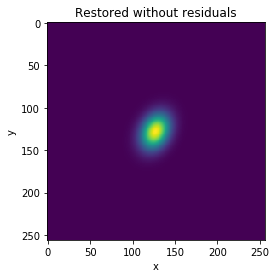

In [18]:
plt.imshow(restorednores[i], interpolation='none')
plt.title('Restored without residuals')
plt.xlabel('x')
plt.ylabel('y')

Text(0, 0.5, 'y')

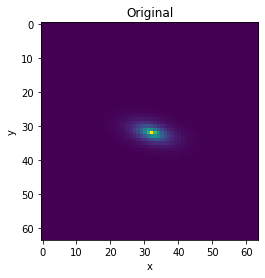

In [19]:
plt.imshow(batch['targets'][i,...,0], interpolation='none')
plt.title('Original')
plt.xlabel('x')
plt.ylabel('y')

Text(0, 0.5, 'y')

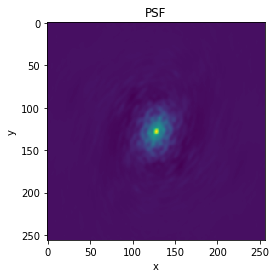

In [20]:
plt.imshow(batch['psf'][i,...,0], interpolation='none')
plt.title('PSF')
plt.xlabel('x')
plt.ylabel('y')

In [21]:
restorednores_resized = np.array([resize(im, (128, 128), interpolation=INTER_AREA) for im in restorednores])

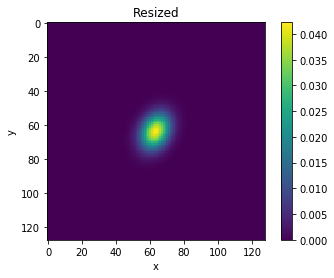

In [22]:
plt.imshow(restorednores_resized[i], interpolation='none')
plt.title('Resized')
plt.xlabel('x')
plt.ylabel('y')
plt.colorbar()

In [23]:
# Generate isotropic Gaussian PSF
# preparing gridding
imsize = 128
x=np.arange(0,imsize)-imsize//2
y=np.arange(0,imsize)-imsize//2
xx,yy=np.meshgrid(x,y)
gauss_iso = gauss2D(xx,yy,1,0,0,2,0.,0.)  # gridx, gridy, amp, meanx, meany, std, e1, e2


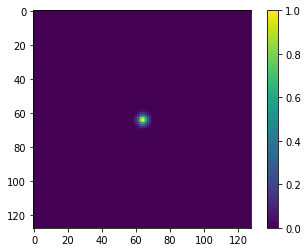

In [24]:
plt.imshow(gauss_iso)
plt.colorbar()

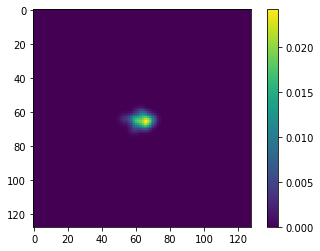

In [25]:
restored_iso = convolve(gauss_iso,skymodelimg[i],'same')
plt.imshow(restored_iso);plt.colorbar()

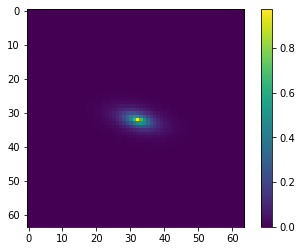

In [26]:
plt.imshow(batch['targets'][i,...,0]);plt.colorbar()